# 1. Libraries/Modules used

In [ ]:
import os
import pickle
import string
import random
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from tensorflow.keras import Model
from keras.layers.merge import add
from multiprocessing import Manager, Pool
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from IPython.display import Image, display
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image

# 2. Google Drive

We have used G-Drive as a temporary storage for image dataset while training the model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Image_captioning_Dataset.zip 

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._34295

**Note:** We have manually uplaoded the pickle file to colab workspace and reading the same here from the workspace filesystem.

In [ ]:
object = pd.read_pickle(r'/content/set_0.pkl')

In [ ]:
input = pd.Series(object)

# 3. EDA

In [ ]:
caption_pd = input.str.split('#\d*\t', expand=True)
caption_pd = caption_pd.applymap(lambda x: x.strip())
caption_pd.columns = ["image_name", "caption"]

In [ ]:
caption_pd.head()

,image_name,caption
0,318667317_108c402140.jpg,A man in a black hoodie be hold a paper sign .
1,2072574835_febf0c5fb9.jpg,Three race dog be run out of the start gate on...
2,3083016677_5782bc337c.jpg,Two motorcycle with two rider each .
3,95734038_2ab5783da7.jpg,A man on a bike nest to a river .
4,241346146_f27759296d.jpg,A football player try tackle another player wh...


In [ ]:
tokens = {}

for ix in range(len(input)-1):
    temp = input[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

## 3.1 EDA-Print the images adn Corresponding captions

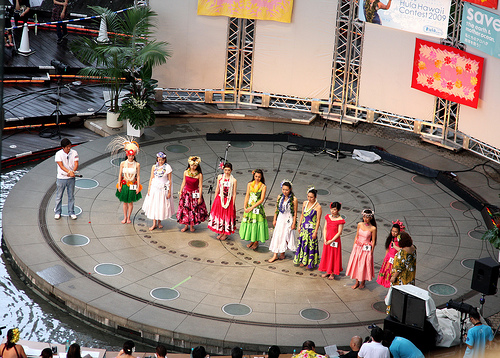

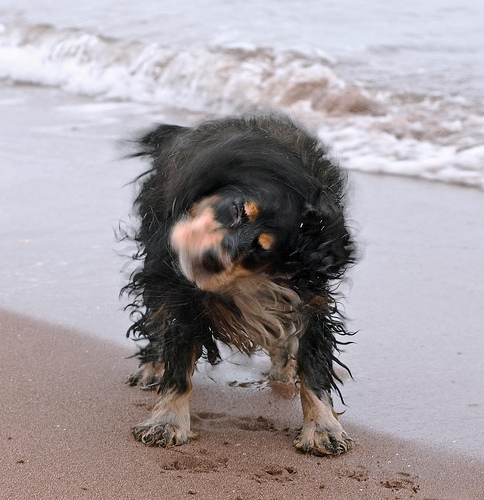

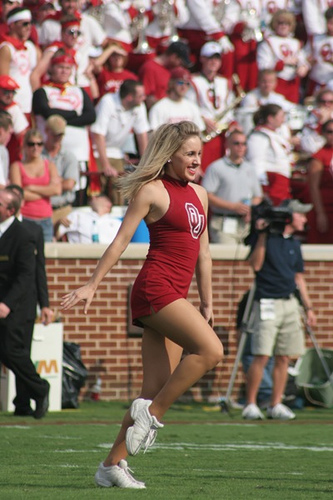

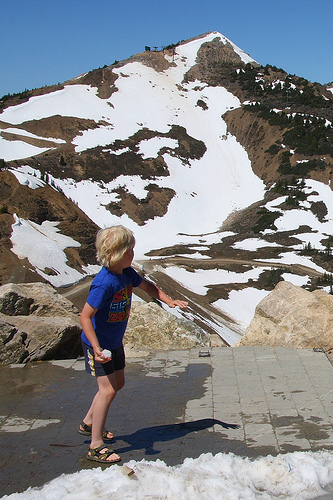

A line of woman dress in colorful gown stand on a round stage .
Young woman in dress stand on a stage
Several young woman in tropical clothing stand on a stage .
Several woman wear bright dress be in a competition .
Woman line up on state in festive dress in front of an audience .
A black dog shake itself dry on a beach in front of the wave .
A dog shake off after come out of the ocean .
dog shake off water by the ocean
A dog be shake itself dry on a beach next to the ocean .
A dog be shake off his fur in front of the water .
A cheerleader dress in red smile and cheer .
A woman in a red suit be run in a field in front of a crowd .
A smile blond cheerleader run with an audience in the background .
A child in short throw a snowball at a mountain .
A boy in a blue shirt be stand at the foot of a hill with a snowball in his hand .
A boy in a t-shirt and short be hold a snowball and face a snowy mountain .
A blond hair boy in short , short sleeve shirt and sandal in overlook a snowcapped mo

In [ ]:
images_path = "/content/Flicker8k_Dataset/"

for i in range(4):
  index=random.randint(0, len(input)-1)
  z = Image(filename=images_path+caption_pd.image_name[index])
  display(z)

  for ix in range(len(tokens[caption_pd.image_name[index]])):
      print(tokens[caption_pd.image_name[index]][ix])


## 3.2 EDA-Check the data size

In [ ]:
print("Total Count: "+ str(caption_pd['image_name'].count()))
print("Total Unique Count: "+ str(pd.Series(caption_pd['image_name'].unique()).count()))

Total Count: 25000
Total Unique Count: 8037


In [ ]:
train_image_names, test_image_names = train_test_split(pd.Series(caption_pd['image_name'].unique()), test_size=0.2)
train_image_names, val_image_names = train_test_split(train_image_names, test_size=0.2)

In [ ]:
train_caption_pd = caption_pd[caption_pd['image_name'].isin(train_image_names)]
test_caption_pd = caption_pd[caption_pd['image_name'].isin(test_image_names)]
val_caption_pd = caption_pd[caption_pd['image_name'].isin(val_image_names)]

## 3.3 EDA - Feature Extractor

Defined a function takes the image folder path as input and does a feature extraction using Pretrained **ResNet-50** CNN Modle.

In [ ]:
def feature_extractor(path):
    model = ResNet50(weights='imagenet') #, include_top = False
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    for layer in model.layers:
        layer.trainable = False
    
    print(model.summary())

    features = {}
    ctr=0
    for image_name in tqdm(os.listdir(path)):
        if ix == "":
          continue
        ctr+=1
        if ctr%1000==0:
          print(ctr)
        image = load_img(path + '/' + image_name, target_size=(224,224)) #224, 224
        image = img_to_array(image)
        
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)

        feature = model.predict(image, verbose=0)

        image_id = image_name.split('.')[0]

        features[image_id] = feature
        
    return features

features = feature_extractor(images_path)

102981632/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

 12%|█▏        | 999/8091 [01:49<12:43,  9.29it/s]

1000


 25%|██▍       | 2001/8091 [03:24<09:23, 10.81it/s]

2000


 37%|███▋      | 3000/8091 [04:58<08:13, 10.31it/s]

3000


 49%|████▉     | 4001/8091 [06:28<05:53, 11.58it/s]

4000


 62%|██████▏   | 4999/8091 [08:03<04:52, 10.59it/s]

5000


 74%|███████▍  | 6000/8091 [09:36<03:03, 11.37it/s]

6000


 87%|████████▋ | 7001/8091 [11:07<01:41, 10.72it/s]

7000


 99%|█████████▉| 8001/8091 [12:41<00:08, 10.60it/s]

8000


100%|██████████| 8091/8091 [12:49<00:00, 10.52it/s]


## 4. Caption Pre-Processing

In [ ]:
import re

def generate_caption_dict(captions):
    caption_dict = {}
    for caption in tqdm(captions):
        aux = re.split('#\d*\t', caption) 
        caption_dict[aux[0]] = aux[1]
        
    return caption_dict
caption_dict = generate_caption_dict(input)


100%|██████████| 25000/25000 [00:00<00:00, 447306.54it/s]


Men play soccer in a field


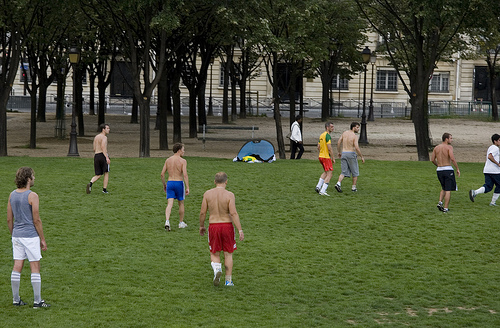

<Figure size 432x288 with 0 Axes>

In [ ]:
for image in random.sample(list(caption_dict), 1):
    plt.figure()
    print(caption_dict[image])
    z = Image(filename=images_path + image)
    display(z)

In [ ]:
def process_captions(caption_dict):
    table = str.maketrans('', '', string.punctuation)
    for image in tqdm(caption_dict):
        caption = caption_dict[image]
        caption = caption.lower()
        caption = caption.split()
        caption = [w.translate(table) for w in caption]
        caption = [w for w in caption if len(w) > 1]
        caption = [w for w in caption if w.isalpha()]
        
        caption_dict[image] = caption
    return caption_dict
        
caption_dict = process_captions(caption_dict)

100%|██████████| 8037/8037 [00:00<00:00, 72369.61it/s]


In [ ]:
def add_seq_tokens(caption_dict):
    for item in tqdm(caption_dict):
        caption = caption_dict[item]
        
        final = '<startseq> ' + ' '.join(caption) + ' <endseq>'
        caption_dict[item] = final
        
    return caption_dict
        
caption_dict = add_seq_tokens(caption_dict)

100%|██████████| 8037/8037 [00:00<00:00, 518617.54it/s]


In [ ]:
list_of_captions = [i for i in caption_dict.values()]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list_of_captions)
vocab_size = len(tokenizer.word_index) + 1
print('Total vocabulary size: ', vocab_size)

Total vocabulary size:  3454


In [ ]:
max_caption_length = max([len(i) for i in list_of_captions])
print('Max Caption lenght: ', max_caption_length)

Max Caption lenght:  168


In [ ]:
def generate_model_inputs(caption_dict, tokenizer, max_caption_length, vocab_size, features):
    Xi, Xt, y = [], [], []
    for key, item in tqdm(caption_dict.items()):

        sequence = tokenizer.texts_to_sequences([item])[0]

        for i in range(1, len(sequence)):

            input_, output_ = sequence[:i], sequence[i]
            input_ = pad_sequences([input_], maxlen=max_caption_length)[0]
            output_ = to_categorical([output_], num_classes=vocab_size)[0]

            try:
              a = features[key.replace('.jpg', '')][0]
              Xi.append(a)
              Xt.append(input_)
              y.append(output_)
            except:
              try:
                print("Here")
              except:
                print('Already Deleted')
            
    return np.array(Xi), np.array(Xt), np.array(y)

# 5. Test-Train Split

In [ ]:
X = list(caption_dict.keys())
X_train, X_val = train_test_split(X, test_size=0.1, random_state=42)
X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42)

print('Train images dataset size: ', len(X_train))
print('Validation images dataset size: ', len(X_val))
print('Test images dataset size: ', len(X_test))

Train images dataset size:  6509
Validation images dataset size:  804
Test images dataset size:  724


In [ ]:
caption_dict_train = {i:caption_dict[i] for i in caption_dict if i in X_train}
caption_dict_val = {i:caption_dict[i] for i in caption_dict if i in X_val}
caption_dict_test = {i:caption_dict[i] for i in caption_dict if i in X_test}

print('Train captions dataset size: ', len(caption_dict_train))
print('Validation captions dataset size: ', len(caption_dict_val))
print('Test captions dataset size: ', len(caption_dict_test))

Train captions dataset size:  6509
Validation captions dataset size:  804
Test captions dataset size:  724


In [ ]:
Xi_train, Xt_train, y_train = generate_model_inputs(caption_dict_train, tokenizer, max_caption_length, vocab_size, features) 
Xi_val, Xt_val, y_val = generate_model_inputs(caption_dict_val, tokenizer, max_caption_length, vocab_size, features) 
Xi_test, Xt_test, y_test = generate_model_inputs(caption_dict_test, tokenizer, max_caption_length, vocab_size, features)

 66%|██████▌   | 4265/6509 [00:02<00:01, 1588.48it/s]

Here
Here
Here
Here
Here


100%|██████████| 724/724 [00:00<00:00, 2022.63it/s]


# 6. Decoder/Caption Generator Model

In [ ]:
def CaptionNetwork(vocab_size, max_caption_length):
    
    img_input_ = Input(shape=(Xi_train.shape[1],)) # 4096
    img_input = Dense(256, activation='relu')(img_input_)
    
    img_input_.trainable = False 
    print("max_caption_length: " + str(max_caption_length))
    # Sequence Model
    text_input_ = Input(shape=(max_caption_length,))
    text_input = Embedding(vocab_size, 256, mask_zero=True)(text_input_)
    text_input = LSTM(256,return_sequences=True)(text_input)
    text_input = LSTM(256, return_sequences=True)(text_input)
    text_input = LSTM(256, return_sequences=True)(text_input)
    text_input = LSTM(256, return_sequences=False)(text_input)
    dec = add([img_input, text_input])
    dec = Dense(256, activation='relu')(dec)
    dec = Dense(vocab_size, activation='softmax')(dec)
    
    model = Model(inputs=[img_input_, text_input_], outputs=dec)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    for l in model.layers:
        print(l.name, l.trainable)
        
    return model

In [ ]:
net = CaptionNetwork(vocab_size, max_caption_length)
print('Model Created')
plot_model(net)

model_save_path = 'model-{epoch}-{val_loss}.hd5'

check = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor="val_loss", mode='min', patience=5, verbose=1, restore_best_weights=True)

print('Model Fitting')
history = net.fit(
    [Xi_train, Xt_train],
    y_train,
    batch_size = 64,
    epochs=5,
    callbacks= [check, early_stop],
    verbose=1,
    validation_data=([Xi_val, Xt_val], y_val)
) 

max_caption_length: 168
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 168)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 168, 256)     884224      ['input_3[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 168, 256)     525312      ['embedding[0][0]']              
                                                                                                  
 lstm_1 (LSTM)                  (None, 168, 256)     525312      ['lstm[0][0]']                   
                                                                    

INFO:tensorflow:Assets written to: model-1-4.483353137969971.hd5/assets


INFO:tensorflow:Assets written to: model-1-4.483353137969971.hd5/assets


1025/1025 [==============================] - 3010s 3s/step - loss: 4.8798 - accuracy: 0.1754 - val_loss: 4.4834 - val_accuracy: 0.2159
Epoch 2/5
1025/1025 [==============================] - ETA: 0s - loss: 4.0535 - accuracy: 0.2358
Epoch 2: val_loss improved from 4.48335 to 4.22119, saving model to model-2-4.221194744110107.hd5


INFO:tensorflow:Assets written to: model-2-4.221194744110107.hd5/assets


INFO:tensorflow:Assets written to: model-2-4.221194744110107.hd5/assets


1025/1025 [==============================] - 3030s 3s/step - loss: 4.0535 - accuracy: 0.2358 - val_loss: 4.2212 - val_accuracy: 0.2391
Epoch 3/5
1025/1025 [==============================] - ETA: 0s - loss: 3.6725 - accuracy: 0.2651
Epoch 3: val_loss improved from 4.22119 to 4.12364, saving model to model-3-4.123643398284912.hd5


INFO:tensorflow:Assets written to: model-3-4.123643398284912.hd5/assets


INFO:tensorflow:Assets written to: model-3-4.123643398284912.hd5/assets


1025/1025 [==============================] - 3023s 3s/step - loss: 3.6725 - accuracy: 0.2651 - val_loss: 4.1236 - val_accuracy: 0.2654
Epoch 4/5
1025/1025 [==============================] - ETA: 0s - loss: 3.4020 - accuracy: 0.2874
Epoch 4: val_loss improved from 4.12364 to 4.10817, saving model to model-4-4.108165740966797.hd5


INFO:tensorflow:Assets written to: model-4-4.108165740966797.hd5/assets


INFO:tensorflow:Assets written to: model-4-4.108165740966797.hd5/assets


1025/1025 [==============================] - 3037s 3s/step - loss: 3.4020 - accuracy: 0.2874 - val_loss: 4.1082 - val_accuracy: 0.2707
Epoch 5/5
1025/1025 [==============================] - ETA: 0s - loss: 3.1779 - accuracy: 0.3052
Epoch 5: val_loss did not improve from 4.10817
1025/1025 [==============================] - 2997s 3s/step - loss: 3.1779 - accuracy: 0.3052 - val_loss: 4.1963 - val_accuracy: 0.2717


# 7. Validation/Verification

In [ ]:
def plot_accuracy(history, miny=None):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    train_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.legend()
    if miny:
        plt.ylim(miny, 1.0)
    plt.title('Training and validation accuracy') 
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.figure()
    
    plt.plot(epochs, train_loss, label='Trainging loss')
    plt.plot(epochs, validation_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

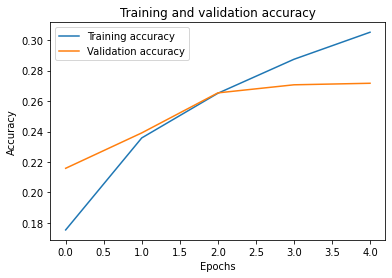

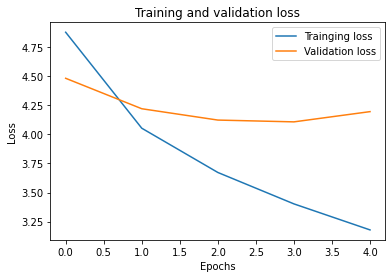

225/225 - 38s - loss: 4.2265 - accuracy: 0.2681 - 38s/epoch - 170ms/step
Accuracy: 26.81%


In [ ]:
plot_accuracy(history)
scores = net.evaluate([Xi_test, Xt_test], y_test,verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

# 8. Caption Generator

In [ ]:
def word_to_id(id_, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == id_:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    # Starts the process
    in_text = '<startseq>'
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_hat = model.predict([photo, sequence], verbose=0)
        y_hat = np.argmax(y_hat)
        pred_word = word_to_id(y_hat, tokenizer)
        
        if pred_word is None or pred_word == '<endseq>' or pred_word == 'endseq':
            in_text += ' ' + '<endseq>'
            break
            
        in_text += ' ' + pred_word
    return in_text

## 8.1 Caption generated for a image from Test set

In [ ]:
def plot_photo_description(model, descriptions, features, tokenizer, max_lenght): 
    for image in random.sample(list(descriptions), 1):
        desc = generate_desc(model,tokenizer,features[image.replace('.jpg', '')], max_lenght)
        plt.figure()
        print(desc)
        im = img.imread(images_path + image)
        plt.imshow(im) 

<startseq> black and white dog be run through the grass <endseq>


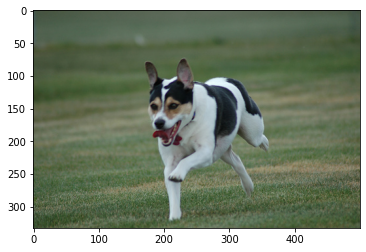

In [ ]:
plot_photo_description(net, caption_dict_test, features, tokenizer, max_caption_length)

## 8.2 Caption Generated for a **Random** image from Internet

In [ ]:
 features_fromGoogleFile = feature_extractor("/content/testfolder")

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


<startseq> golden dog be run through the snow <endseq>


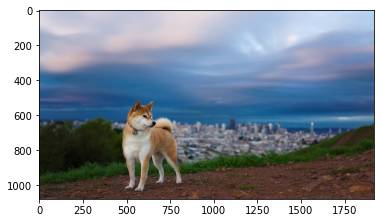

In [ ]:
desc = generate_desc(net,tokenizer,features_fromGoogleFile, max_caption_length)
plt.figure()
print(desc)
im = img.imread(("/content/testfolder/testfilefromGoogle.jpg"))
plt.imshow(im)

## 9. Sequence Parity Function using RNN
- Let us define a sequence parity function as a function that takes in a sequence of binary inputs and returns a sequence indicating the number of 1’s in the input so far; specifically, if at time t the 1’s in the input so far is odd it returns 1, and 0 if it is even. For example, given input sequence [0, 1, 0, 1, 1, 0], the parity sequence is [0, 1, 1, 0, 1, 1]. 
- Implement the minimal vanilla recurrent neural network to learn the parity function. Explain your rationale using a state transition diagram and parameters of the network.

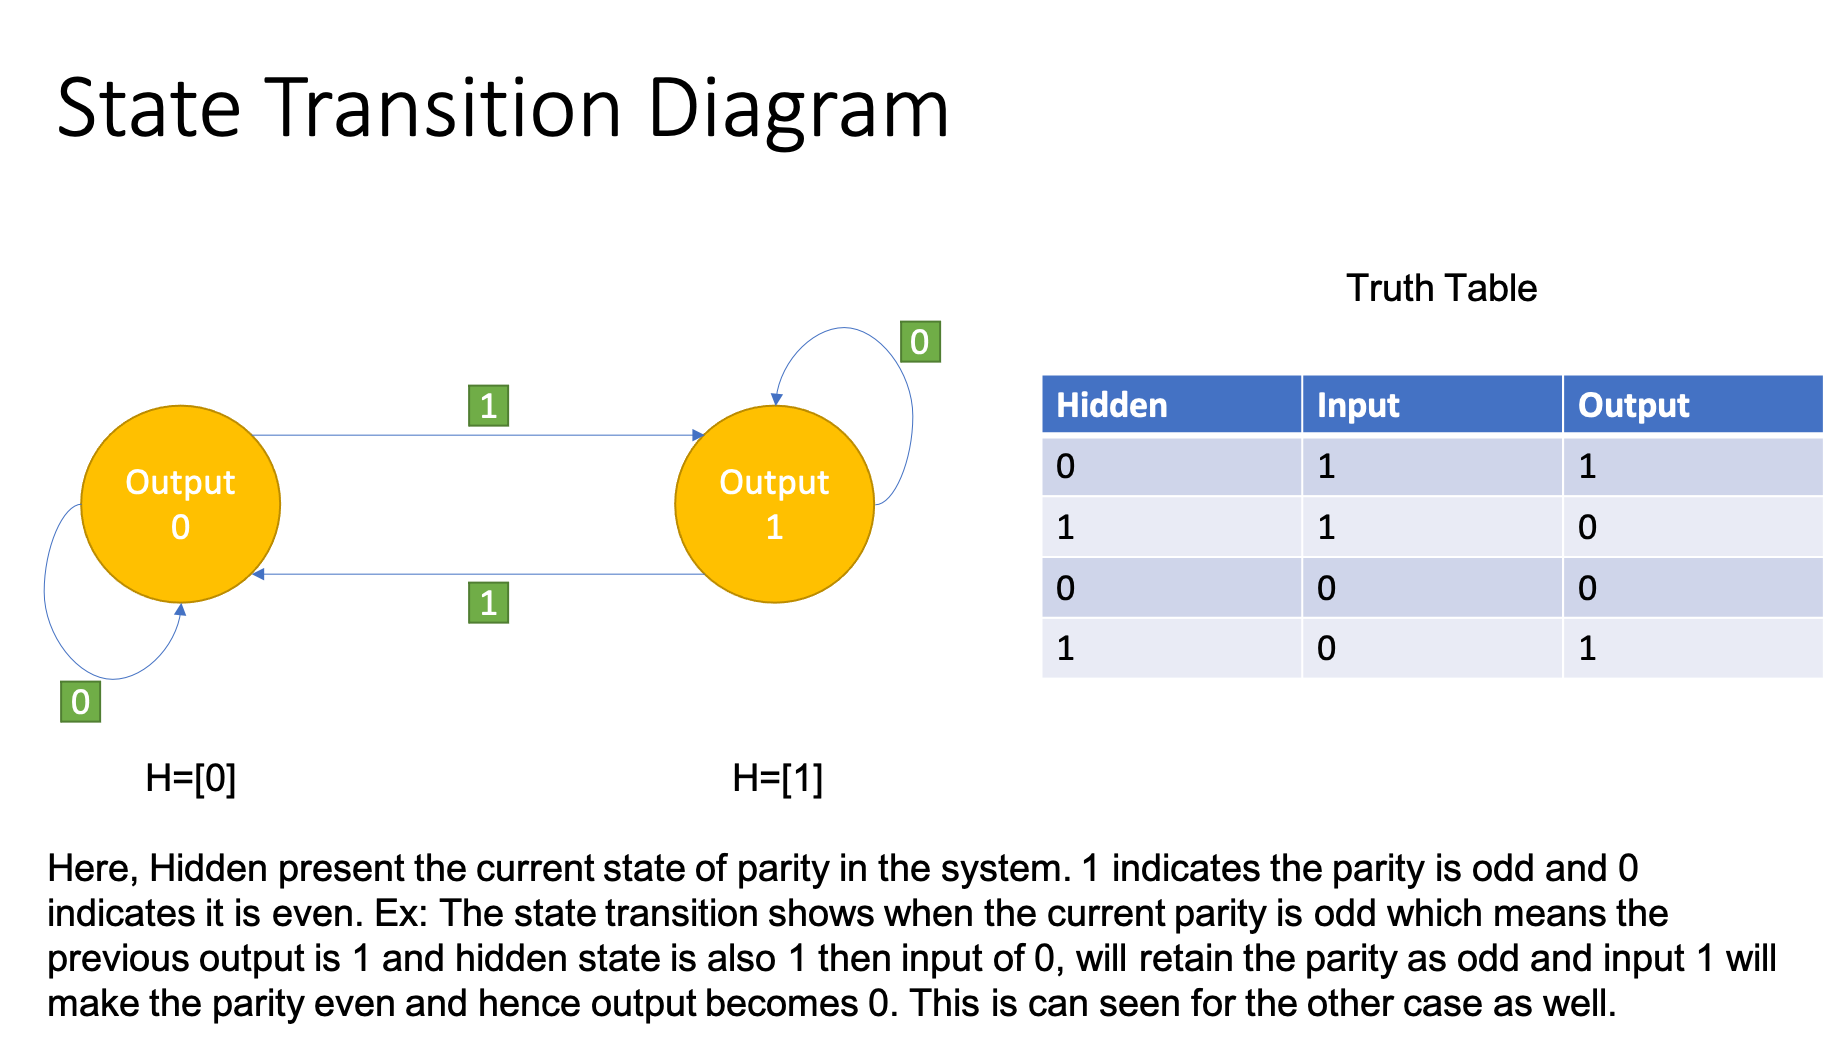

In [9]:
from IPython.display import Image
Image(filename='Picture1.png')

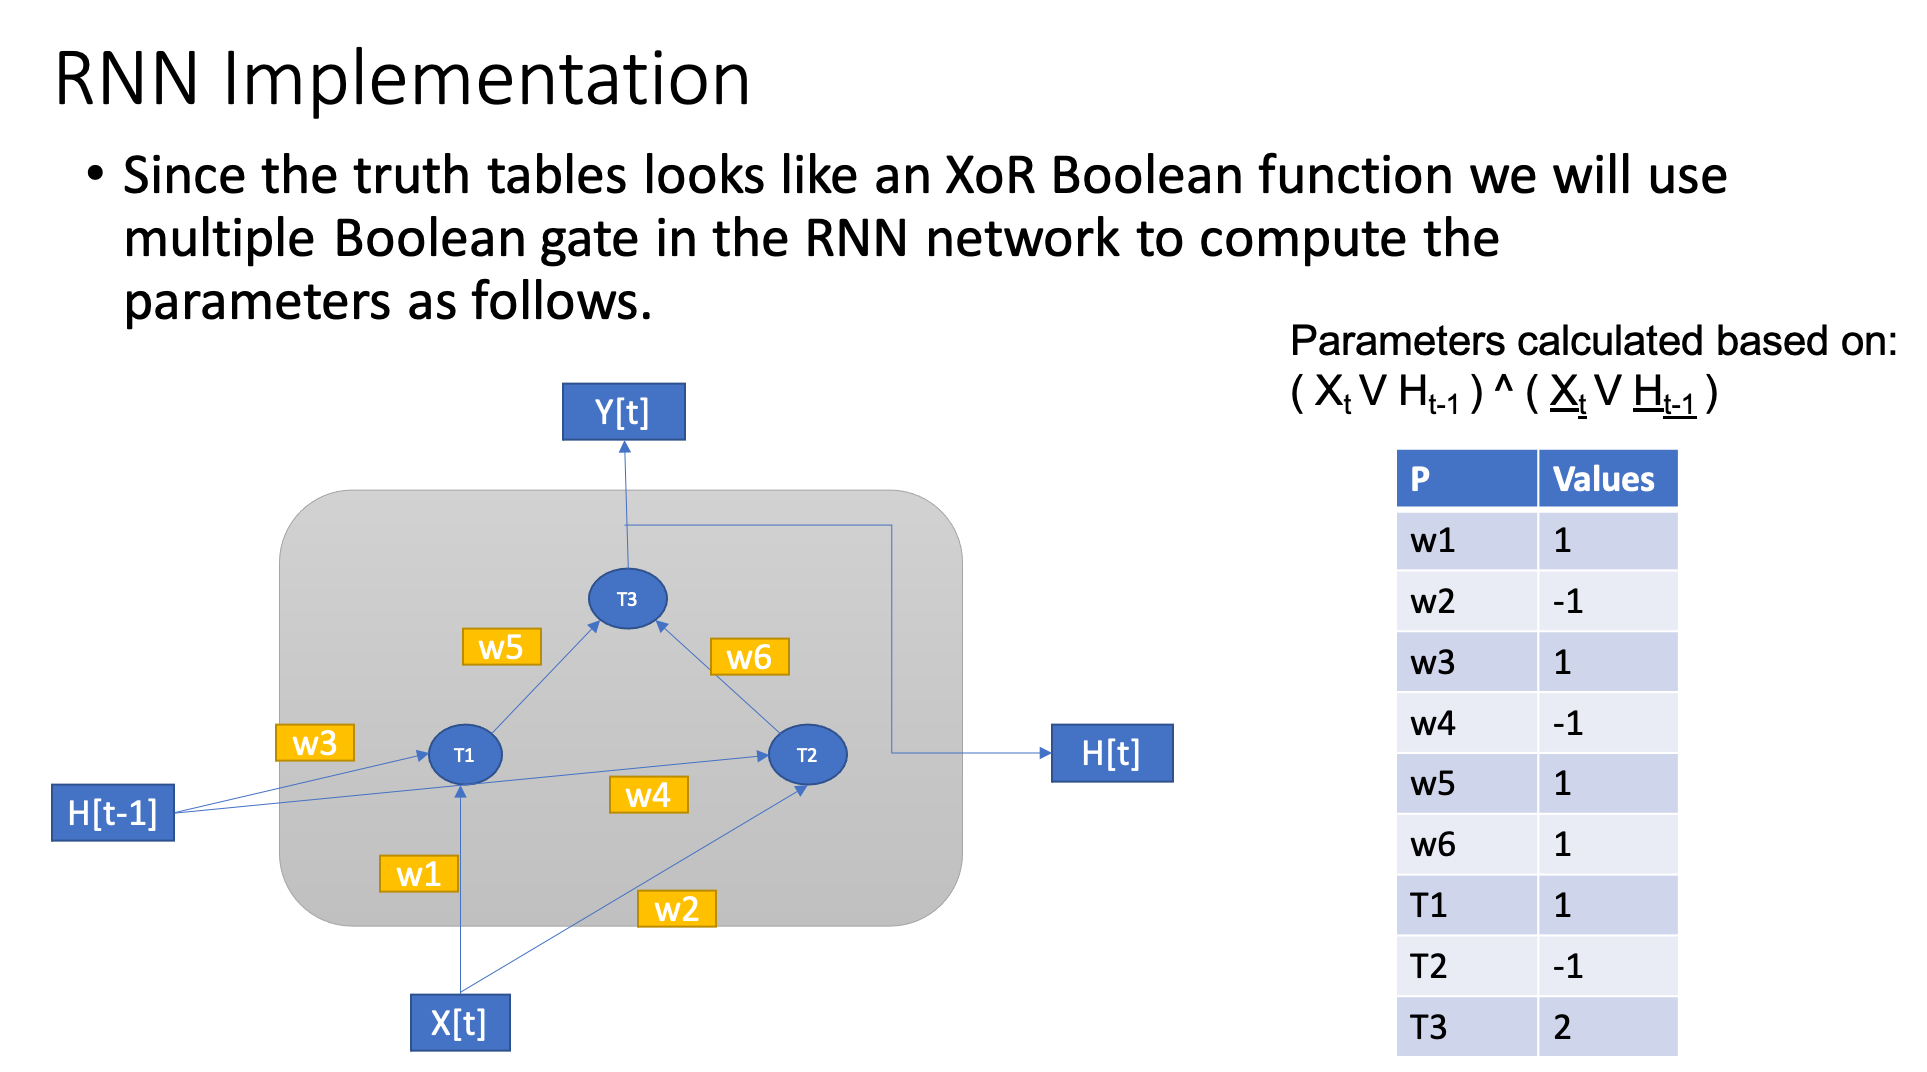

In [8]:
from IPython.display import Image
Image(filename='Picture2.png')

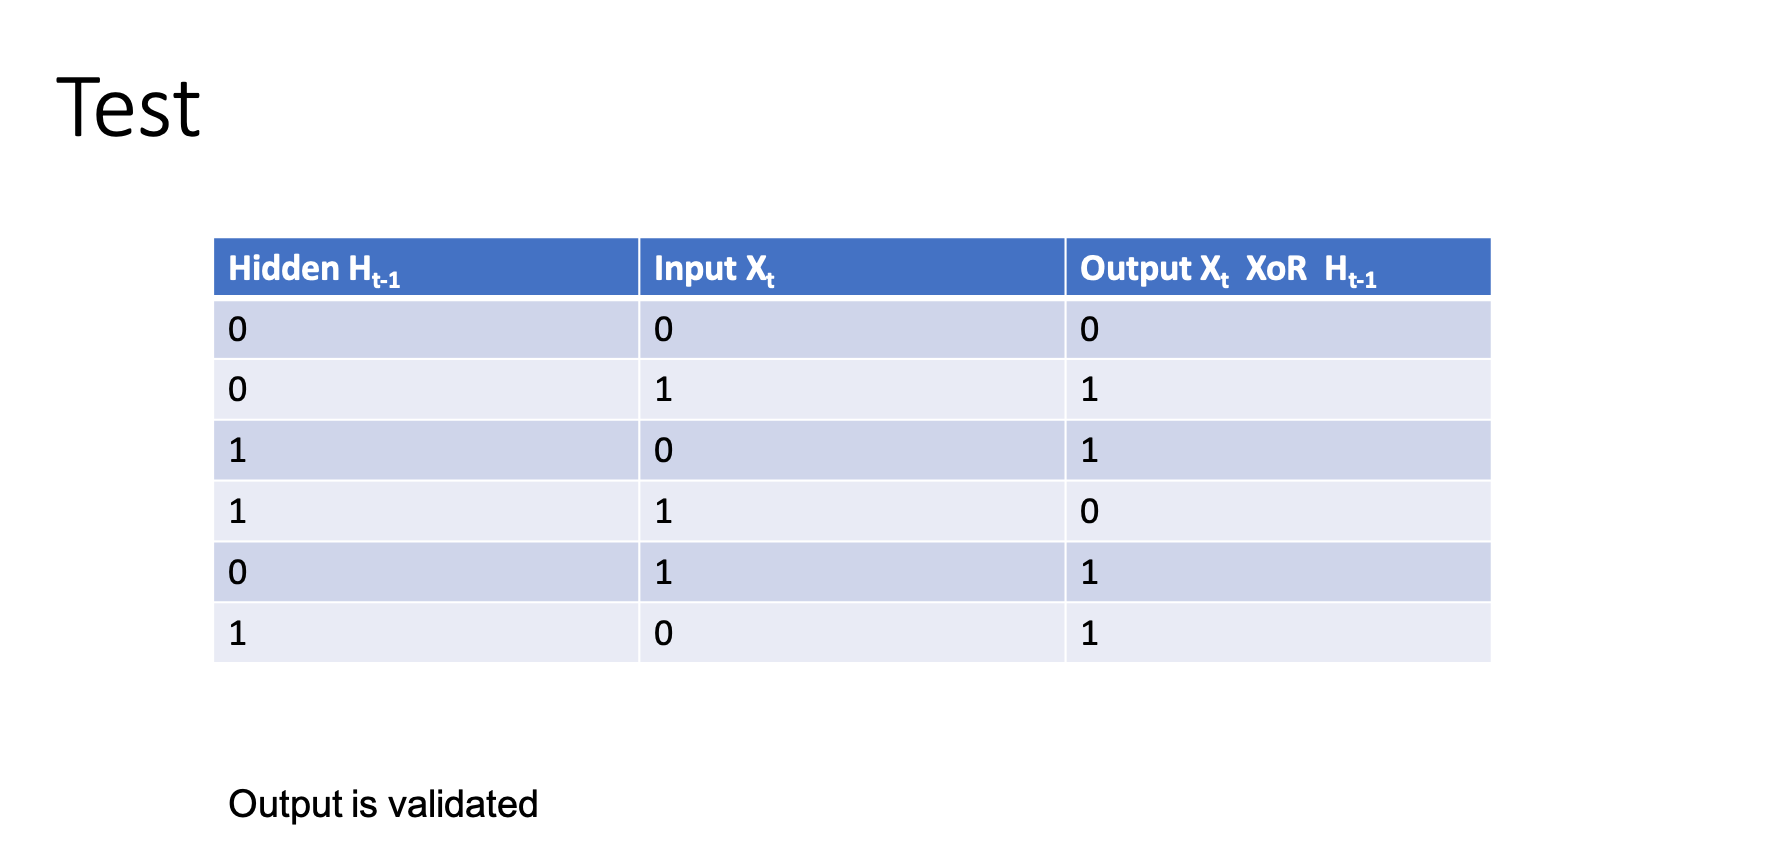

In [7]:
from IPython.display import Image
Image(filename='Picture3.png')